In [1]:
# disable warning
import os; os.environ['PYGSTI_BACKCOMPAT_WARNING'] = '0'

import pygsti
import numpy as np

import matplotlib.pyplot as plt

ws = pygsti.report.Workspace()
ws.init_notebook_mode(autodisplay=True)

In [7]:
import qiskit
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error
from qiskit.quantum_info.operators import Kraus, SuperOp
from qiskit.quantum_info.operators.channel.choi import Choi
from qiskit.tools.qi.qi import choi_to_rauli

# Asymmetric Depolarizing Channel

Empirically, noise classification was shown to perform well when 

$$
p_x + p_y + p_z \leq \sin^2(\pi / 8) \approx 0.15
$$

as seen in the `xyz_classification.ipynb` notebook.

In [17]:
def gen_error_channel(p_x, p_y, p_z, verbose=False):
    assert(p_x > 0 and p_y > 0 and p_z > 0 and p_x + p_y + p_z <= 1)
    if verbose: print("px + py + pz: ", p_x + p_y + p_z)
    return pauli_error([
    ('X', p_x),
    ('Y', p_y),
    ('Z', p_z),
    ('I', (1-p_x-p_y-p_z))
    ])

In [18]:
p_x = 0.04
p_y = 0.08
p_z = 0.02

In [19]:
error_channel = gen_error_channel(p_x, p_y, p_z, verbose=True)

def error_channel_to_choi(error_channel):
    # choi representation
    error_channel_choi = Choi(error_channel)
    # change to pauli basis
    # NOTE - choi matrix should have trace 1 ... looks like qiskit does not normalize
    error_channel_superop = choi_to_rauli(error_channel_choi.data / np.trace(error_channel_choi.data)) 
    
    # hermitian R-basis so elements should be real    
    return error_channel_superop.real

error_channel_superop = error_channel_to_choi(error_channel)

px + py + pz:  0.13999999999999999


In [20]:
gi_nn = np.identity(4,'d') # 4x4 identity matrix
gx_nn = [[1, 0, 0, 0],
      [0, 1, 0, 0],
      [0, 0, 0,-1],
      [0, 0, 1, 0]] # pi/2 X-rotation in Pauli basis

gy_nn = [[1, 0, 0, 0],
      [0, 0, 0, 1],
      [0, 0, 1, 0],
      [0,-1, 0, 0]] # pi/2 Y-rotation in Pauli basis
      
def gen_error_model(error_channel_superop):
    # apply error channel

    gi = np.dot(error_channel_superop, gi_nn)
    gx = np.dot(error_channel_superop, gx_nn)
    gy = np.dot(error_channel_superop, gy_nn)

    #mdl0 = pygsti.construction.build_explicit_model((0), [(),      ('Gx',0),    ('Gy',0)], ["I(0)","X(pi/2,0)", "Y(pi/2,0)"]) 
    #print(mdl0)

    # Initialize an empty Model object
    # Designate the basis being used for the matrices and vectors below 
    # as the "Pauli product" basis of dimension 2 - i.e. the four 2x2 Pauli matrices I,X,Y,Z

    mdl = pygsti.objects.ExplicitOpModel(['Q0'],'pp') # default is pauli basis, but emphasized because modifiable 

    #Populate the Model object with states, effects, gates,
    # all in the *normalized* Pauli basis: { I/sqrt(2), X/sqrt(2), Y/sqrt(2), Z/sqrt(2) }
    # where I, X, Y, and Z are the standard Pauli matrices.

    mdl['rho0'] = [ 1/np.sqrt(2), 0, 0, 1/np.sqrt(2) ] # density matrix [[1, 0], [0, 0]] in Pauli basis
    mdl['Mdefault'] = pygsti.objects.UnconstrainedPOVM(
        {'0': [ 1/np.sqrt(2), 0, 0, 1/np.sqrt(2) ],   # projector onto [[1, 0], [0, 0]] in Pauli basis
         '1': [ 1/np.sqrt(2), 0, 0, -1/np.sqrt(2) ] }) # projector onto [[0, 0], [0, 1]] in Pauli basis

    mdl['Gi'] = gi
    mdl['Gx'] = gx

    mdl['Gy'] = gy
    return mdl

mdl = gen_error_model(error_channel_superop)
print(mdl)


rho0 = FullSPAMVec with dimension 4
 0.71   0   0 0.71


Mdefault = UnconstrainedPOVM with effect vectors:
0: FullSPAMVec with dimension 4
 0.71   0   0 0.71

1: FullSPAMVec with dimension 4
 0.71   0   0-0.71



Gi = 
FullDenseOp with shape (4, 4)
 1.00   0   0   0
   0 0.80   0   0
   0   0 0.88   0
   0   0   0 0.76


Gx = 
FullDenseOp with shape (4, 4)
 1.00   0   0   0
   0 0.80   0   0
   0   0   0-0.88
   0   0 0.76   0


Gy = 
FullDenseOp with shape (4, 4)
 1.00   0   0   0
   0   0   0 0.80
   0   0 0.88   0
   0-0.76   0   0






In [21]:
from pygsti.construction import std1Q_XYI

# 1) get the target Model
mdl_ideal = std1Q_XYI.target_model()

# 2) get the building blocks needed to specify which circuits are needed
prep_fiducials, meas_fiducials = std1Q_XYI.prepStrs, std1Q_XYI.effectStrs

print("Prep Strs: ", prep_fiducials)
print("Effect Strs: ", meas_fiducials)

germs = std1Q_XYI.germs
maxLengths = [1] # roughly gives the length of the sequences used by GST

print("Germs: ", germs)

listOfExperiments = pygsti.construction.make_lsgst_experiment_list(
    mdl_ideal, prep_fiducials, meas_fiducials, germs, maxLengths)

Prep Strs:  [Circuit({}), Circuit(Gx), Circuit(Gy), Circuit(GxGx), Circuit(GxGxGx), Circuit(GyGyGy)]
Effect Strs:  [Circuit({}), Circuit(Gx), Circuit(Gy), Circuit(GxGx), Circuit(GxGxGx), Circuit(GyGyGy)]
Germs:  [Circuit(Gi), Circuit(Gx), Circuit(Gy), Circuit(GxGy), Circuit(GxGxGy), Circuit(GxGyGy), Circuit(GxGyGi), Circuit(GxGiGy), Circuit(GxGiGi), Circuit(GyGiGi), Circuit(GxGyGyGi), Circuit(GxGxGyGxGyGy)]


In [22]:
def generate_gst_data(m):
    # add seed for deterministic
    return pygsti.construction.generate_fake_data(m, listOfExperiments, nSamples=1000,
                                            sampleError="binomial")
    
    # to perform GST...
    # pygsti.do_stdpractice_gst(d, mdl_ideal, prep_fiducials, meas_fiducials, 
    #                               germs, maxLengths, modes="TP,Target", verbosity=0)
    
def gen_error_data(kappa, theta, phi):
    error_channel = gen_error_channel(kappa, theta, phi)
    error_channel_superop = error_channel_to_choi(error_channel)
    m = gen_error_model(error_channel_superop)
    return generate_gst_data(m)

def no_noise_gst():
    return generate_gst_data(mdl_ideal)

In [23]:
def get_gst_features(res):
    d = []
    for idx, k in enumerate(res.keys()):
        row = res.get_row(k)
        for lbl in row.counts.keys():
            if idx % 2 == 0:
                d.append(row[lbl] / 1000.)
                
    return np.array(d)

In [24]:
err_fv = get_gst_features(
            gen_error_data(p_x, p_y, p_z)
            )

nn_fv = get_gst_features(
            no_noise_gst()
            )

print("no noise: ", nn_fv)
print("noisy: ", err_fv)

no noise:  [1.    0.    0.487 0.513 0.516 0.484 0.523 0.477 0.493 0.507 0.    1.
 0.466 0.534 0.493 0.507 0.502 0.498 0.    1.    0.497 0.503 0.487 0.513
 1.    0.    0.505 0.495 0.502 0.498 0.524 0.476 0.521 0.479 1.    0.
 0.487 0.513 0.    1.    0.476 0.524 0.    1.    0.483 0.517 0.496 0.504
 0.471 0.529 0.464 0.536 0.    1.    0.504 0.496 1.    0.    0.515 0.485
 0.    1.    1.    0.    0.49  0.51  1.    0.    0.    1.    0.503 0.497
 1.    0.    0.514 0.486 0.518 0.482 0.516 0.484 0.491 0.509 0.    1.
 0.503 0.497 0.    1.    0.495 0.505 0.482 0.518]
noisy:  [1.    0.    0.493 0.507 0.486 0.514 0.527 0.473 0.506 0.494 0.199 0.801
 0.483 0.517 0.507 0.493 0.475 0.525 0.356 0.644 0.525 0.475 0.516 0.484
 0.871 0.129 0.475 0.525 0.525 0.475 0.499 0.501 0.497 0.503 0.692 0.308
 0.497 0.503 0.274 0.726 0.462 0.538 0.237 0.763 0.521 0.479 0.505 0.495
 0.511 0.489 0.498 0.502 0.368 0.632 0.494 0.506 0.649 0.351 0.509 0.491
 0.268 0.732 0.651 0.349 0.497 0.503 0.649 0.351 0.424 0.576 0.4

92


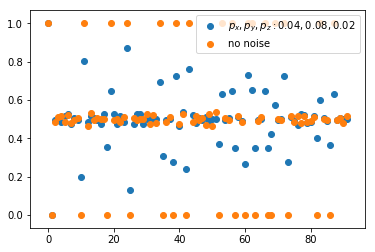

In [26]:
plt.figure()

print(len(err_fv))

plt.scatter(np.arange(92), err_fv, label=r"$p_x, p_y, p_z: %.2f,%.2f,%.2f$" % (p_x, p_y, p_z))
plt.scatter(np.arange(92), nn_fv, label="no noise")

plt.legend()

plt.show()

In [27]:
from tqdm.autonotebook import tqdm, trange # progress bar

/opt/anaconda3/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning:

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)



In [32]:
class Trial:
    def __init__(self, p_num, p_min, p_max):
        self.size = p_num 
        self.trials = np.linspace(p_min, p_max, p_num)
    
class TrialGroup:
    def __init__(self, px: Trial, py: Trial, pz: Trial):
        self.px = px
        self.py = py
        self.pz = pz
        
        self.combinations = px.size * py.size * pz.size


tg = TrialGroup(
    Trial(9, 1e-3, 1e-1),
    Trial(9, 1e-3, 1e-1),
    Trial(9, 1e-3, 1e-1)
    
)


sample_trials = 10

In [47]:
# no noise trials

nn_fm = []
for i in trange(sample_trials):
    nn_fv = get_gst_features(
            no_noise_gst()
            )
    
    # (px, py, pz) = (0., 0., 0.)
    nn_fv = np.append(nn_fv, (0., 0., 0.))
    # category 0 (no noise)
    nn_fv = np.append(nn_fv, 0) 
    
    nn_fm.append(nn_fv)

nn_fm = np.array(nn_fm)
    

In [34]:
# noisy trials

err_fm = []

# sample trials per (\kappa, \theta, \phi)
for i in trange(sample_trials):
    for px in tqdm(tg.px.trials):
        for py in tg.py.trials:
            for pz in tg.pz.trials:
                err_fv = get_gst_features(
                    gen_error_data(px, py, pz)
                )

                # noise features
                err_fv = np.append(err_fv, [px, py, pz])
                
                # category 1 (noisy)
                err_fv = np.append(err_fv, 1) 

                err_fm.append(err_fv)

err_fm = np.array(err_fm)
    

In [48]:
# overwrite value in persistent store

%store nn_fm
%store err_fm

Stored 'nn_fm' (ndarray)
Stored 'err_fm' (ndarray)


In [ ]:
# reload value
%store -r

In [197]:
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

data = np.concatenate((err_fm, nn_fm))

# only train with gst data as feature vectors
X = data[:, :92]
print(len(X[0]))

# use noise class as labelling
y = data[:, -1]
y_pz = data[:, -2]
y_py = data[:, -3]
y_px = data[:, -4]

ss = StandardScaler()
data_std = ss.fit_transform(X)

pca = PCA(2)
data_trans = pca.fit_transform(data_std)

print("Explained variance: ", pca.explained_variance_ratio_)
print("Singular values: ", pca.singular_values_)

92
Explained variance:  [0.28602797 0.03003915]
Singular values:  [433.49783603 140.48388189]


In [50]:
# grid for plotting decision bdry

x_min = np.min(data_trans[:,0])
x_max = np.max(data_trans[:, 0])
y_min = np.min(data_trans[:, 1])
y_max = np.max(data_trans[:, 1])
h = .02  # step size in the mesh

cm = plt.cm.RdBu

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

grid = np.c_[xx.ravel(), yy.ravel()]

def get_contour_map(clf):
    Z = clf.predict(grid) 
    return Z.reshape(xx.shape)

# SVM Classification

In [53]:
# RBF kernel
clf = svm.SVC(kernel='rbf', gamma='auto')

def fit_and_score_svm(clf, data, lbl):
    clf.fit(data, lbl)
    acc = clf.score(data, lbl)
    print("acc: ", acc)
    # contour to plot decision boundary
    Z = get_contour_map(clf)
    return acc, Z

px_labels = ((tg.px.size - 1) * y_px / np.max(tg.px.trials)).astype(int)
py_labels = ((tg.py.size - 1) * y_py / np.max(tg.py.trials)).astype(int)
pz_labels = ((tg.pz.size - 1) * y_pz / np.max(tg.pz.trials)).astype(int)

In [54]:
acc, Z = fit_and_score_svm(clf, data_trans, y)
print("px...")
acc_px, Z_px = fit_and_score_svm(clf, data_trans, px_labels)
print("py...")
acc_py, Z_py = fit_and_score_svm(clf, data_trans, py_labels)
print("pz...")
acc_pz, Z_pz = fit_and_score_svm(clf, data_trans, pz_labels)

acc:  1.0
px...
acc:  0.47054794520547943
py...
acc:  0.36506849315068496
pz...
acc:  0.22356164383561644


In [118]:
class Scatter:
    def __init__(self, data: list, label: str):
        self.data = data
        self.label = label

class Contour:
    def __init__(self, Z, color_map):
        self.Z = Z
        self.color_map = color_map
    
class Plot:
    def __init__(self, scatters: list, contour: Contour, title: str):
        self.scatters = scatters
        self.contour = contour
        self.title = title
    
def show_plots(plots, contour=False):
    plt.figure(figsize=(20, 40))
    
    for idx, plot in enumerate(plots):
        plt.subplot(len(plots), 1, idx + 1)
        
        for s in plot.scatters:
            plt.scatter(s.data[:, 0], s.data[:, 1], label=s.label, edgecolors='k')
            
        if contour: plt.contourf(xx, yy, plot.contour.Z, alpha=.5, cmap = plot.contour.color_map)
            
        plt.legend()
        plt.title(plot.title)

    plt.show()

In [115]:
plot_data = [
    Plot(
        [
            Scatter(data_trans[y == 0], 'Noisy'),
            Scatter(data_trans[y == 1], 'No noise')
        ],
        Contour(Z, cm),
        "No noise and noisy (acc: %f)" % acc
        
    ), 
    Plot(
        [
            Scatter(data_trans[y_px == p], str(p)) for p in tg.px.trials
        ],
        Contour(Z_px, 'Pastel1'),
        r"Varying $p_x$ (acc: %f)" % acc_px
        
    ),
    Plot(
        [
            Scatter(data_trans[y_py == p], str(p)) for p in tg.py.trials
        ],
        Contour(Z_py, 'Pastel1'),
        r"Varying $p_y$ (acc: %f)" % acc_py
        
    ),
    Plot(
        [
            Scatter(data_trans[y_pz == p], str(p)) for p in tg.pz.trials
        ],
        Contour(Z_pz, 'Pastel1'),
        r"Varying $p_z$ (acc: %f)" % acc_pz,
    )
]

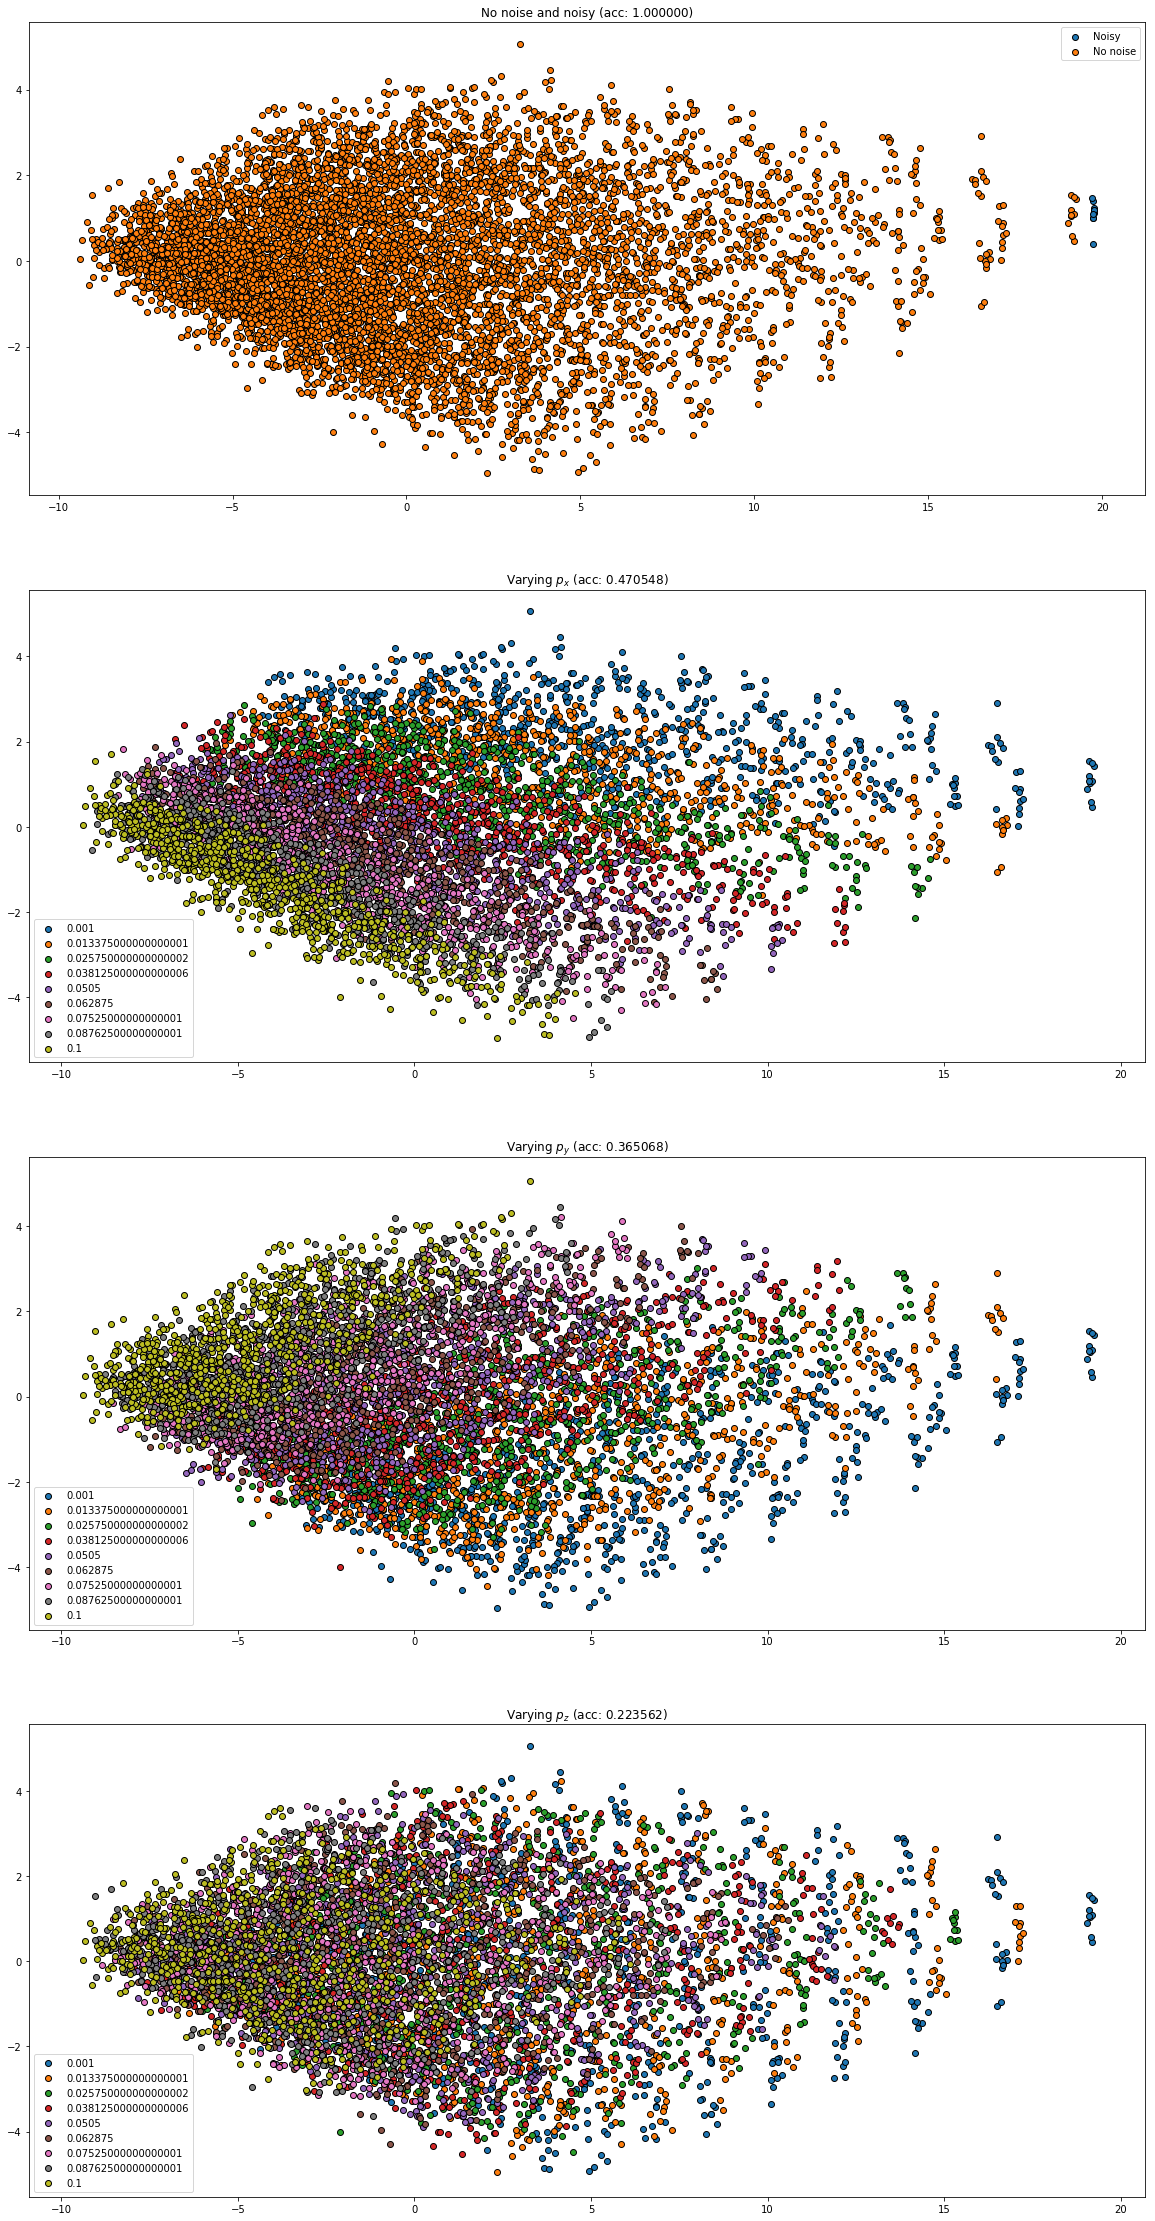

In [116]:
show_plots(plot_data)

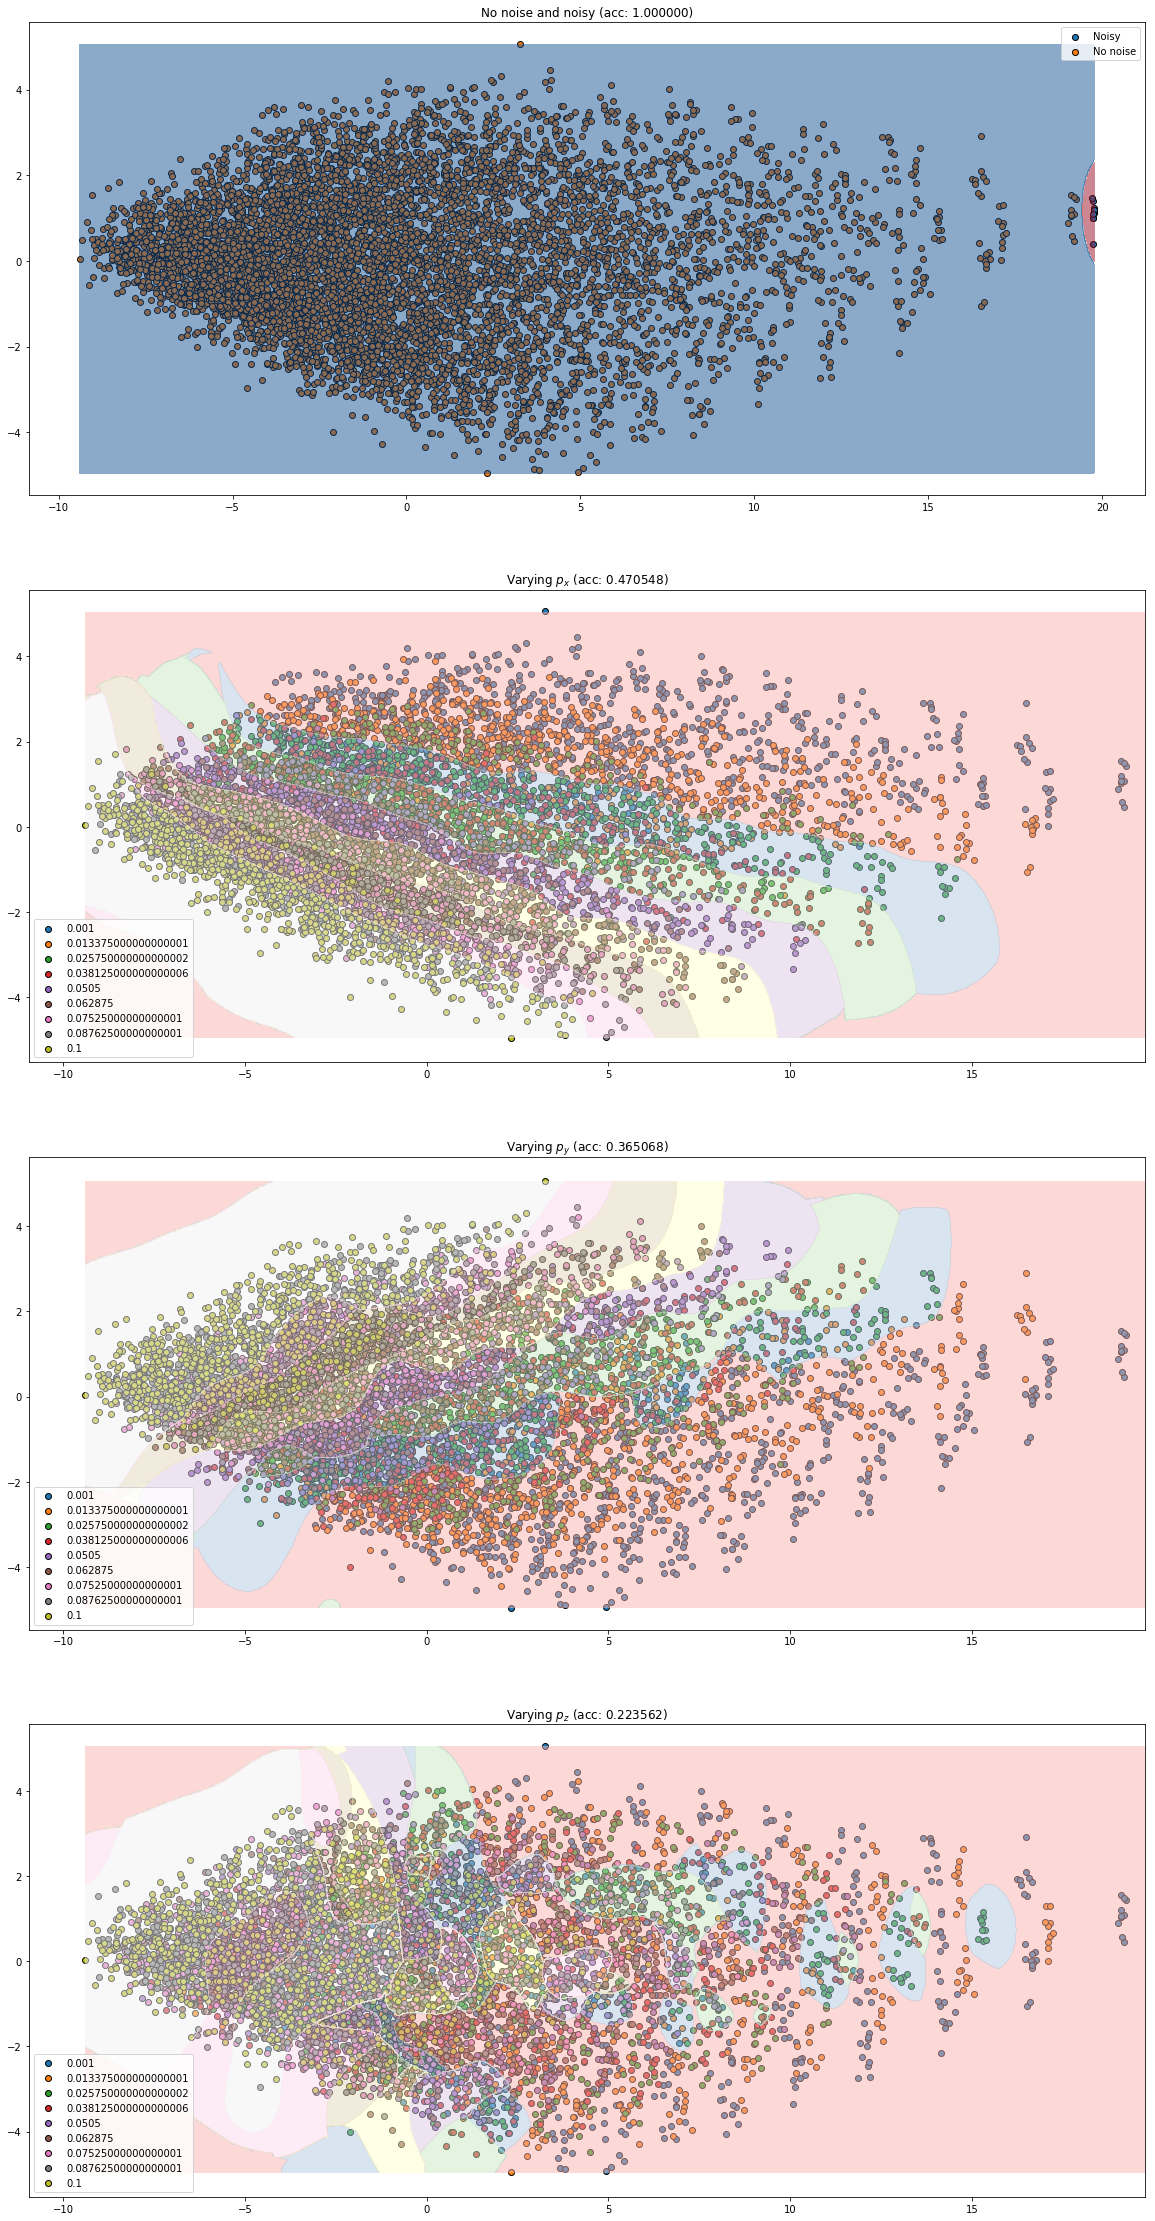

In [119]:
show_plots(plot_data, True)

SVM does not perform exceptionally well, but there is clearly a nice structure to the data especially in the $\sigma_x, \sigma_y$ case. We still see substantial improvement over random guessing which would classify correctly w.p. $\approx 0.11$. We can expect to perform much better if the spacing is increased between probability classes. **In any event, this problem is better posed as a regression one because misclassifications are likely often to an adjacent class.**

# NN Classification -- 92 Dimensions

In [65]:
import torch
import torch.optim as optim
from sklearn.model_selection import train_test_split

device = None
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print(device)

cuda


In [186]:
def nn_train_model(data, labels, steps, num_classes):
    
    dt_train, lt_train = \
        torch.from_numpy(data).float().to(device=device), \
        torch.from_numpy(labels).to(device=device)

    num_inputs = len(data[0])
    H = max(num_inputs, num_classes)
    
    # N is batch size; D_in is input dimension;
    # H is hidden dimension; D_out is output dimension.
    N, D_in, H1, H2, D_out = 64, num_inputs, H, H, num_classes

    # Use the nn package to define our model as a sequence of layers
    model = torch.nn.Sequential(
        torch.nn.Linear(D_in, H1),
        torch.nn.ReLU(),
        torch.nn.Linear(H1, H2),
        torch.nn.ReLU(),
        torch.nn.Linear(H2, D_out),
    ).to(device=device)

    # stochastic gradient descent w/ hessian
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    # ll loss for classification
    loss_fn = torch.nn.CrossEntropyLoss()

    learning_rate = 1e-4
    with trange(steps) as tr:
        for t in tr:
            # Forward pass: compute predicted y by passing x to the model
            y_pred = model(dt_train)

            # Compute and print loss
            loss = loss_fn(y_pred, lt_train)
            tr.set_description("Loss: %f" % loss.item())

            # Zero the gradients before running the backward pass.
            optimizer.zero_grad()

            # Backward pass: compute gradient of the loss with respect to all the learnable
            # parameters of the model.
            loss.backward()
            # Step
            optimizer.step()
            
    return model
    

In [139]:
from sklearn.metrics import accuracy_score

def get_preds(model, data):
    o = model(data)
    _, pred = torch.max(o, 1)
    return pred

In [163]:
def nn_get_contour_map(model):
    preds = get_preds(model, torch.from_numpy(grid).float().to(device=device))
    return preds.reshape(xx.shape)

In [184]:
def train_and_test(data, labels, num_classes, steps, contour=False):
    dt_train, dt_test, lt_train, lt_test = train_test_split(
        data, labels, test_size=0.2, random_state=42) # seed
    
    model = nn_train_model(dt_train, lt_train, steps=steps, num_classes=num_classes)
    
    tr_preds = get_preds(model, torch.from_numpy(dt_train).float().to(device=device))
    ts_preds = get_preds(model, torch.from_numpy(dt_test).float().to(device=device))
    
    print("training accuracy: ", accuracy_score(tr_preds.cpu(), lt_train))
    print("test accuracy: ", accuracy_score(ts_preds.cpu(), lt_test))
    
    return nn_get_contour_map(model).cpu() if contour else None
    
    

In [151]:
train_and_test(data_std, px_labels, num_classes=tg.px.size, steps=5000)

training accuracy:  0.7912671232876712
test accuracy:  0.7267123287671233


In [76]:
train_and_test(data_std, py_labels, num_classes=tg.py.size, steps=5000)

training accuracy:  0.7308219178082191
test accuracy:  0.6568493150684932


In [77]:
train_and_test(data_std, pz_labels, num_classes=tg.pz.size, steps=5000)

training accuracy:  0.536986301369863
test accuracy:  0.48561643835616436


The neural network performs well and even seems to generalize. This is particularly impressive noting how small the spacing is between each probability class! Do note that we are considering all 92 dimensions in this case, however. Hence, we better try with only the two PCA dimensions to properly compare. We can then plot the contours in the 2D projection plane similarly to before.

# NN Classification -- 2 PCA Dimensions

In [187]:
nn_Z_px = train_and_test(data_trans, px_labels, num_classes=tg.px.size, steps=5000, contour=True)

training accuracy:  0.4613013698630137
test accuracy:  0.45136986301369864


In [188]:
nn_Z_py = train_and_test(data_trans, py_labels, num_classes=tg.py.size, steps=5000, contour=True)

training accuracy:  0.3333904109589041
test accuracy:  0.3404109589041096


In [ ]:
nn_Z_pz = train_and_test(data_trans, pz_labels, num_classes=tg.pz.size, steps=5000, contour=True)

In [190]:
nn_plot_data = [
    Plot(
        [
            Scatter(data_trans[y_px == p], str(p)) for p in tg.px.trials
        ],
        Contour(nn_Z_px, 'Pastel1'),
        r"Varying $p_x$ (acc: %f)" % acc_px
        
    ),
    Plot(
        [
            Scatter(data_trans[y_py == p], str(p)) for p in tg.py.trials
        ],
        Contour(nn_Z_py, 'Pastel1'),
        r"Varying $p_y$ (acc: %f)" % acc_py
        
    ),
    Plot(
        [
            Scatter(data_trans[y_pz == p], str(p)) for p in tg.pz.trials
        ],
        Contour(nn_Z_pz, 'Pastel1'),
        r"Varying $p_z$ (acc: %f)" % acc_pz,
    )
]

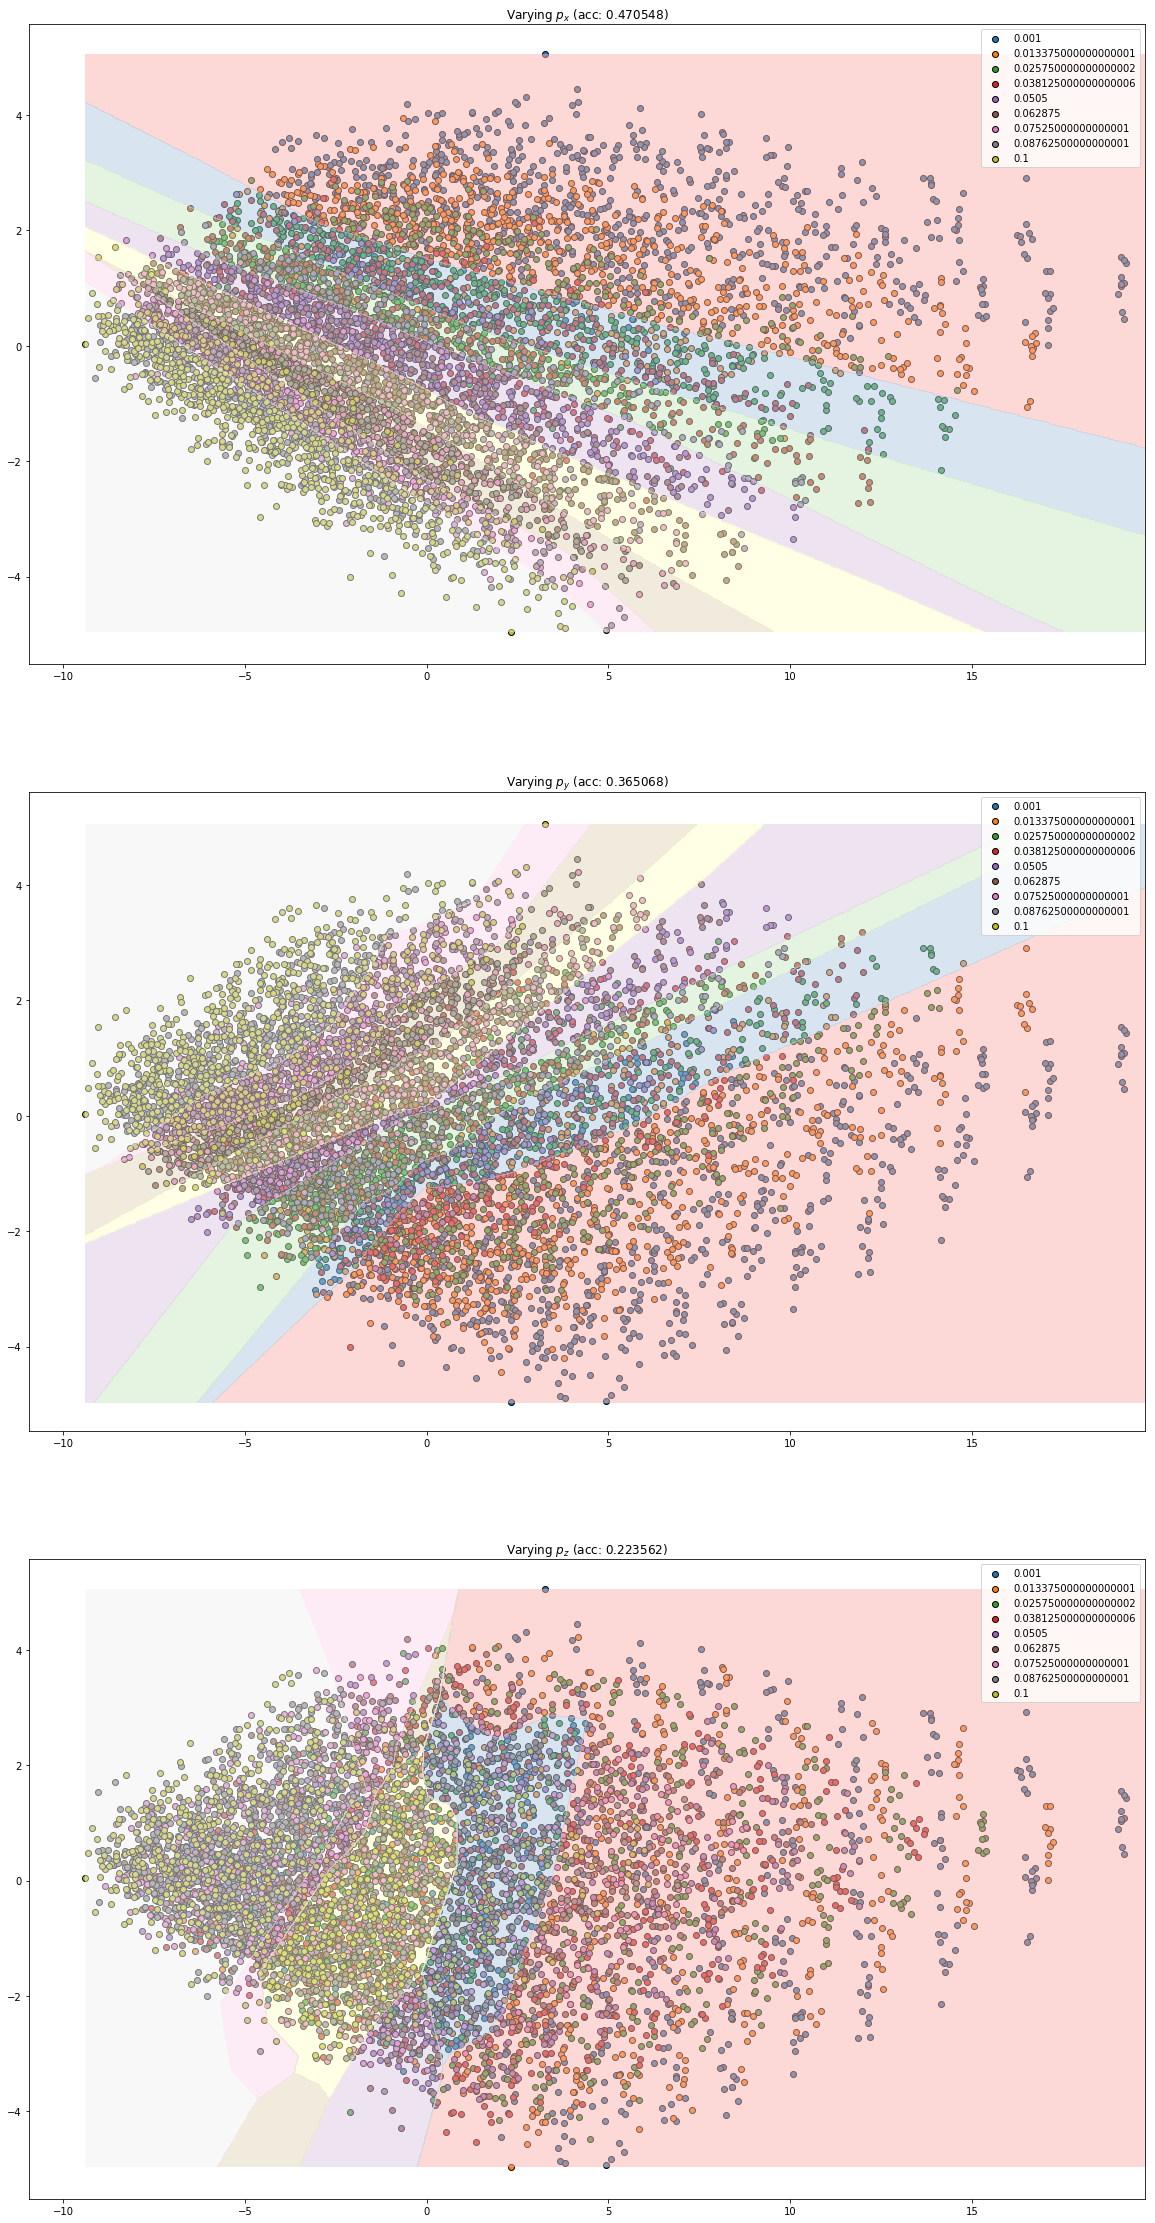

In [191]:
show_plots(nn_plot_data, True)

# NN Regression

Let us reformulate in terms of a more suitable regression problem...

We will us quantum relative entropy as our loss function. In the ML community, they call this method of comparing probability distributions "Kullback–Leibler divergence". In particular, each feature corresponds to a distribution $(1-p_{total}, p_x, p_y, p_z)$. Let our neural network perform softmax (actually log softmax to work with log probabilities for better numerical performance) at the last layer of four neurons so that we can interpet the output as a distribution. For example, data vector $\vec{x}$ may give probabilities $\hat{y} = (\hat{y}_1, \hat{y}_2, \hat{y}_3, \hat{y}_4$ with true values $y = (y_1, y_2, y_3, y_4)$. Our loss function on a single feature vector gives

$$
l(y \mid\mid \hat{y}) = y \log(y / \hat{y})
$$

Hence, on a batch we are comparing the distributions by $H(Y , \hat{Y}) - H(Y)$ (note: asymmetric) where $H(\cdot, \cdot)$ is the cross-entropy.


In [354]:
def nn_regress(data, labels, steps):
    
    dt_train, lt_train = \
        torch.from_numpy(data).float().to(device=device), \
        torch.from_numpy(labels).float().to(device=device)

    H = num_inputs = len(data[0])
    
    # N is batch size; D_in is input dimension;
    # H is hidden dimension; D_out is output dimension.
    N, D_in, H1, H2, D_out = 64, num_inputs, H, H, 4

    # Use the nn package to define our model as a sequence of layers
    model = torch.nn.Sequential(
        torch.nn.Linear(D_in, H1),
        torch.nn.ReLU(),
        torch.nn.Linear(H1, H2),
        torch.nn.ReLU(),
        torch.nn.Linear(H2, D_out),
        torch.nn.LogSoftmax()
    ).to(device=device)

    # stochastic gradient descent w/ hessian
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    # ll loss for classification
    loss_fn = torch.nn.KLDivLoss()

    learning_rate = 1e-4
    with trange(steps) as tr:
        for t in tr:
            # Forward pass: compute predicted y by passing x to the model
            y_pred = model(dt_train)

            # Compute and print loss
            loss = loss_fn(y_pred, lt_train)
            tr.set_description("Loss: %f" % loss.item())

            # Zero the gradients before running the backward pass.
            optimizer.zero_grad()

            # Backward pass: compute gradient of the loss with respect to all the learnable
            # parameters of the model.
            loss.backward()
            # Step
            optimizer.step()
            
    return model
    

In [432]:
def accuracy_score_reg(model, data_x, data_y, thresh):
    X = torch.from_numpy(data_x).float().to(device=device)
    Y = torch.from_numpy(data_y).float().to(device=device)
    n_items = len(X)
    oupt = torch.exp(model(X))
    
    print("predicted: ", oupt)
    print("target: ", Y)
    
    loss_fn = torch.nn.L1Loss(reduction="none")
    loss = torch.sum(loss_fn(Y, oupt), 1)
    
    print("mean loss (L1): ", torch.mean(loss).item())
    n_correct = torch.sum( loss < thresh)
    result = (n_correct.item() / n_items)  # scalar
    print("accuracy: ", result)
    
    return oupt

In [444]:
def train_and_test_regress(data, labels, steps):
    dt_train, dt_test, lt_train, lt_test = train_test_split(
        data, labels, test_size=0.2, random_state=42) # seed
    
    model = nn_regress(dt_train, lt_train, steps=steps)
    
    thresh = 0.1
    
    print("training")
    print("accuracy threshold (L1): ", thresh)
    tr_preds = accuracy_score_reg(
            model, dt_train, lt_train, thresh
            )
    
    print("test")
    ts_preds = accuracy_score_reg(
            model, dt_test, lt_test, thresh
            )
    
    return tr_preds.detach().numpy(), ts_preds.detach().numpy(), lt_train, lt_test
    
    

In [436]:
y_reg = data[:, -4:-1]
#f = lambda x, y: x * y
#f_arr = np.frompyfunc(f, 2, 1)
#vf = np.vectorize(f)

def complement(x):
    return 1 - x[0] - x[1] - x[2]

feat_4 = np.apply_along_axis(complement, 1, y_reg)

y_reg = np.vstack( (y_reg.T, feat_4 )).T

print(y_reg)

[[0.001    0.001    0.001    0.997   ]
 [0.001    0.001    0.013375 0.984625]
 [0.001    0.001    0.02575  0.97225 ]
 ...
 [0.       0.       0.       1.      ]
 [0.       0.       0.       1.      ]
 [0.       0.       0.       1.      ]]


In [442]:
tr_preds, ts_preds, lt_train, lt_test = train_and_test_regress(data_std, y_reg, steps=200000)

training
accuracy threshold (L1):  0.1
predicted:  tensor([[0.0047, 0.0060, 0.0069, 0.9824],
        [0.1015, 0.0471, 0.0129, 0.8385],
        [0.0419, 0.0821, 0.0568, 0.8191],
        ...,
        [0.0389, 0.0419, 0.0959, 0.8233],
        [0.0159, 0.0664, 0.0454, 0.8723],
        [0.0969, 0.0939, 0.0962, 0.7131]], device='cuda:0',
       grad_fn=<ExpBackward>)
target:  tensor([[0.0010, 0.0010, 0.0134, 0.9846],
        [0.1000, 0.0381, 0.0258, 0.8361],
        [0.0381, 0.0876, 0.0629, 0.8114],
        ...,
        [0.0381, 0.0505, 0.1000, 0.8114],
        [0.0134, 0.0629, 0.0629, 0.8609],
        [0.1000, 0.0752, 0.0876, 0.7371]], device='cuda:0')
mean loss (L1):  0.03088683821260929
accuracy:  0.9982876712328768
test
predicted:  tensor([[0.0053, 0.0077, 0.0408, 0.9463],
        [0.0714, 0.0047, 0.0392, 0.8847],
        [0.0442, 0.1021, 0.0740, 0.7797],
        ...,
        [0.0888, 0.0790, 0.0575, 0.7747],
        [0.0609, 0.0581, 0.0177, 0.8633],
        [0.0512, 0.0775, 0.0807, 0.79

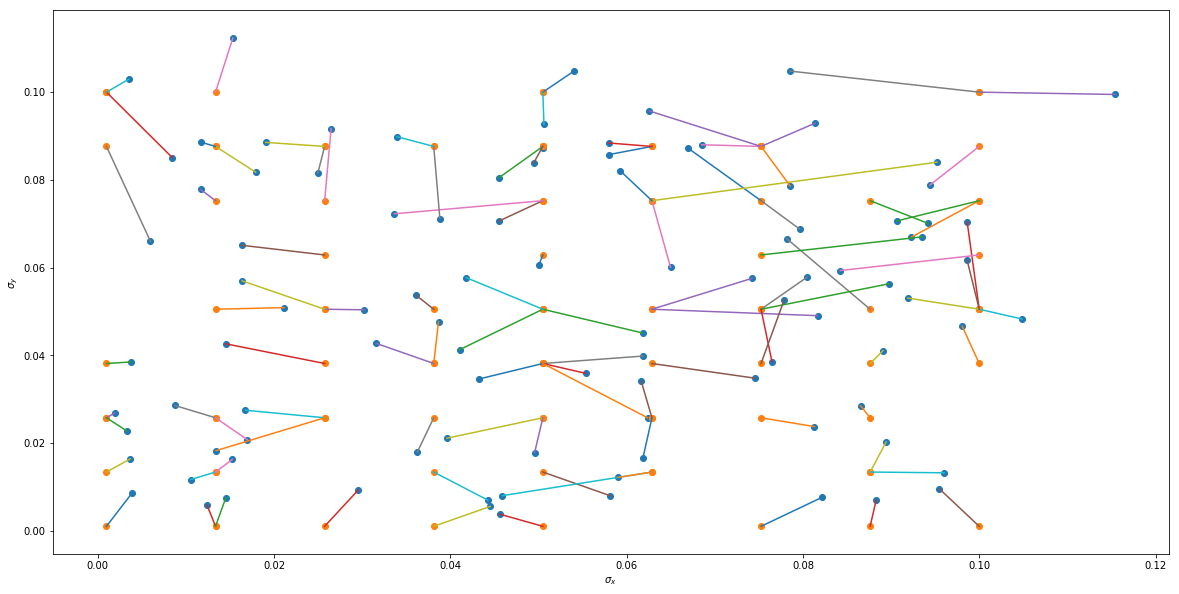

In [497]:
from sklearn.utils.random import sample_without_replacement
%matplotlib inline

plt.rcParams["figure.figsize"] = (20, 10)

idx = sample_without_replacement(len(tr_preds), 100)

for i in idx:
    plt.plot((tr_preds[:, 0][i], lt_train[:, 0][i]), (tr_preds[:, 1][i], lt_train[:, 1][i]))
    
plt.scatter(tr_preds[:, 0][idx], tr_preds[:, 1][idx])
plt.scatter(lt_train[:, 0][idx], lt_train[:, 1][idx])

plt.xlabel(r"$\sigma_x$")
plt.ylabel(r"$\sigma_y$")

plt.show()

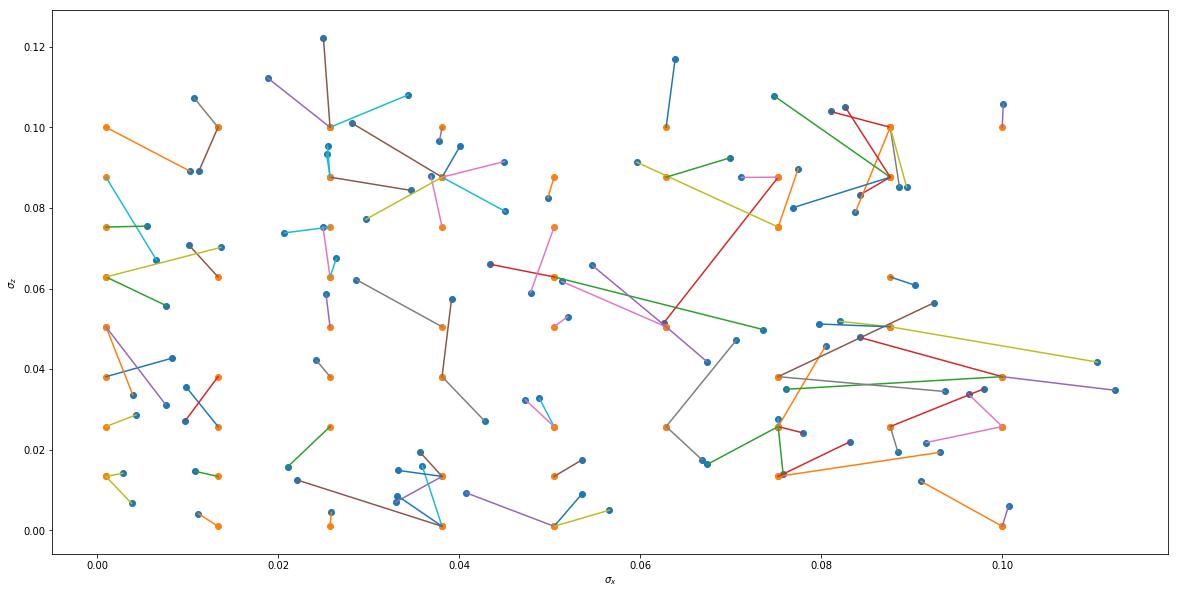

In [498]:
from sklearn.utils.random import sample_without_replacement
%matplotlib inline

plt.rcParams["figure.figsize"] = (20, 10)

idx = sample_without_replacement(len(tr_preds), 100)

for i in idx:
    plt.plot((tr_preds[:, 0][i], lt_train[:, 0][i]), (tr_preds[:, 2][i], lt_train[:, 2][i]))
    
plt.scatter(tr_preds[:, 0][idx], tr_preds[:, 2][idx])
plt.scatter(lt_train[:, 0][idx], lt_train[:, 2][idx])

plt.xlabel(r"$\sigma_x$")
plt.ylabel(r"$\sigma_z$")

plt.show()